# Lending Club Loan Analysis

Lending club follows a P2P system where money is lent/borrowed from one private individual to another. This dataset is taken from Kaggle which is issued by Lending Club. The dataset contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. 

This project accomplishes the following objectives :-
1. Extracting, Loading & Tranforming Data.
2. Data Exploration and visualisation
3. Predicting if the customer will pay off his loans on time or not by building models.
4. Model Evaluation & Final conclusion

In [1]:
# import packages
from pyspark.sql import SparkSession
from pyspark import SparkConf,SparkContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *

from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql import Window


### One of the Main advantages of Spark over scikit-learn,pandas counterpart is its parallel processing power through its individual nodes.
### And its better we utilise it to the maximum

In [2]:

# 8g - gigabyes(gb) of memory - So using 8gb of memory for both driver process & executor process
# 3cores - Utilising 3 cores

config = SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','8g')])
# sc.stop()
sc = SparkContext(conf=config)

spark = SparkSession.builder.config(conf=config).getOrCreate()
sc.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.cores.max', '3'),
 ('spark.driver.host', 'LAPTOP-UP2IV74A'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.memory', '8g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1588362067323'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '55879')]

In [3]:
# expand the output display to see more columns of a pandas DataFrame
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
# This is a function for checking the shape and size
def size_shape(df):
    print("rows:",df.count())
    print("columns:",len(df.columns))


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# 1. EXTRACT - LOAD - TRANSFORM

### This part will go through with our strategies for cleaning the dataset and transformation of the dataset into Machine learning pipelines

### Our basic strategy is to split the whole dataset into parts where each of us work on separate parts where we shall be cleaning the dataset

##### P.S this is quite a lengthy section

In [4]:
# Read the dataset
df = spark.read.csv('C:\\Users\\tigerman381\\Downloads\\lending-club-loan-data\\loan.csv', header=True, inferSchema=True)
# take a look at the first 10 rows
df_pd = df.limit(10).toPandas()
#checking the size & shape
size_shape(df)

#Displaying the head of the dataframe
display(df_pd.head())


rows: 2260668
columns: 145


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,None,None,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000,Not Verified,Dec-2018,Current,n,None,None,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1,None,45,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,None,1,Individual,None,None,None,0,0,16901,2,2,1,2,2,12560,69,2,7,2137,28,42000,1,11,2,9,1878,34360.0,5.9,0.0,0,140.0,212,1,1,0,1.0,NaN,2,NaN,0,2,5,3,3,16,7,18,5,9,0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Cash,N,None,None,None,None,None,None
1,None,None,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000,Source Verified,Dec-2018,Current,n,None,None,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0,71,75,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,None,1,Individual,None,None,None,0,1208,321915,4,4,2,3,3,87153,88,4,5,998,57,50800,2,15,2,10,24763,13761.0,8.3,0.0,0,163.0,378,4,3,3,4.0,NaN,4,NaN,0,2,4,4,9,27,8,14,4,13,0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Cash,N,None,None,None,None,None,None
2,None,None,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280,Source Verified,Dec-2018,Current,n,None,None,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0,None,None,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,Mar-2019,Feb-2019,

### Our Main dependant variable which we are concerned about is the 'Loan_status'. 
In Loan_status column, we want to predict if a particular loan will be charged off or not.


In [5]:

current_df = df.filter(col('loan_status').isin(['Late (31-120 days)','Charged Off','Late (16-30 days)','Current']))
#Renaming the Late values into a single late
current_df = current_df.withColumn("loan_status", \
              when(current_df["loan_status"].isin(['Late (31-120 days)','Late (16-30 days)','Current']),'Not Charged Off').otherwise(current_df["loan_status"]))

#Our dataset with only the desired columns values (Charged off, Not Charged Off)
print(current_df.groupby(current_df.loan_status).count().show())



+---------------+------+
|    loan_status| count|
+---------------+------+
|Not Charged Off|945329|
|    Charged Off|261654|
+---------------+------+

None


## Part 1 (Columns 1 to 25)

### First Let us check the count of NAs to begin with 

In [6]:
# Contains the nas present in all the columns in the dataset. We are planning to remove those coluomns with more than 50%Nas
checkna_pd = current_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in current_df.columns]).toPandas()
checkna_pd

current_df.select([c for c in checkna_pd.columns])

DataFrame[id: string, member_id: string, loan_amnt: int, funded_amnt: int, funded_amnt_inv: double, term: string, int_rate: double, installment: double, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, pymnt_plan: string, url: string, desc: string, purpose: string, title: string, zip_code: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_pymnt_d

### We decided to drop all columns which have NAs more than 50% of the entire dataset.

In [7]:
#https://stackoverflow.com/questions/51322445/how-to-drop-all-columns-with-null-values-in-a-pyspark-dataframe - include in our references

#Creating a dataframe which has the count of Nas of each column
checkna = current_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in current_df.columns])
#Selecting the columns with NA values not greater than 50%
No_of_rows = current_df.count()
checkna_greater_than_50 = checkna.select([when(fn.col(c)<(No_of_rows*0.50),c).alias(c) for c in checkna.columns])


def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    :param df: A PySpark DataFrame
    """
    null_counts = df.select([fn.count(fn.when(fn.col(c).isNull()|isnan(fn.col(c)), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > 0]
    df = df.drop(*to_drop)
    return df

# Using the function to find the list of columns with less than 50%Na values
final_cols = drop_null_columns(checkna_greater_than_50)
current_df1 = current_df.select([fn.col(c) for c in final_cols.columns])

#selecting our dataframe with the final cols


### Now we shall be starting the cleaning part. We have about 100 columns where we understood each variable,looked into it & interpolated NAs or wrong values.



In [8]:
# We are taking the 1st 25 columns as the first part.
part1=current_df1.select(current_df1.columns[0:25])
drop_var=['issue_d','zip_code','earliest_cr_line']
part1=part1.drop(*drop_var)

### Columns with missing values | the number of missing values | explanation of the type of data

emp_title      | 105,247 | The job title supplied by the Borrower when applying for the loan.*

title          | 12,520 | The loan title provided by the borrower

addr_state     | 1 | The state provided by the borrower in the loan application

dti            | 1,456 | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

delinq_2yrs    | 1 | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

inq_last_6mths | 1 | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

open_acc       | 5 | The number of open credit lines in the borrower's credit file.


### NOTE : We have commented out certain codes in order to improve our overall execution time. These commented codes are basically column analysis to help us better understand the values in the columns


In [9]:
# print(part1.groupby(part1.emp_title).count().show())
# print(part1.groupby(part1.addr_state).count().show())
# print(part1.groupby(part1.dti).count().show())
# print(part1.groupby(part1.delinq_2yrs).count().show())



In [10]:
# print(part1.groupby(part1.inq_last_6mths).count().show())
# print(part1.groupby(part1.open_acc).count().show())


In [11]:
# CHeck the columns to see if they are categories
# print(part1.groupby(part1.purpose).count().show())
# print(part1.groupby(part1.pymnt_plan).count().show())
# print(part1.groupby(part1.verification_status).count().show())


In [12]:
# Check the columns to see if they are categories
# print(part1.groupby(part1.term).count().show())
# print(part1.groupby(part1.grade).count().show())
# print(part1.groupby(part1.sub_grade).count().show())
# print(part1.groupby(part1.home_ownership).count().show())


In [13]:
# Make the columns into categories

cat_col=['term','grade','sub_grade','home_ownership','verification_status','loan_status','pymnt_plan']
part1_cat_col=part1.select(cat_col)
# After looking at the values, we have some more columns to drop
drop_var_2=['emp_title',"title",'purpose','emp_length','addr_state']
part1=part1.drop(*drop_var_2)
part1_num_col=part1.drop(*cat_col)


Converting numerical columns to its right type(Float or Int) instead of object.

In [14]:
part1 = part1.withColumn('loan_amnt', part1['loan_amnt'].cast(FloatType()))
part1 = part1.withColumn('funded_amnt', part1['funded_amnt'].cast(FloatType()))
part1 = part1.withColumn('funded_amnt_inv', part1['funded_amnt_inv'].cast(FloatType()))
part1 = part1.withColumn('int_rate',part1['int_rate'].cast(FloatType()))
part1 = part1.withColumn('installment', part1['installment'].cast(FloatType()))
part1 = part1.withColumn('annual_inc', part1['annual_inc'].cast(FloatType()))
part1 = part1.withColumn('dti', part1['dti'].cast(FloatType()))
part1 = part1.withColumn('delinq_2yrs', part1['delinq_2yrs'].cast(IntegerType()))
part1 = part1.withColumn('inq_last_6mths', part1['inq_last_6mths'].cast(IntegerType()))
part1 = part1.withColumn("open_acc",part1["open_acc"].cast(IntegerType()))


### Columns with missing values | the number of missing values | explanation of the type of data

dti            | 1,489 | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

delinq_2yrs    | 31 | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

inq_last_6mths | 24 | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

open_acc       | 23 | The number of open credit lines in the borrower's credit file.


In [15]:
# Lets fill in the values that are missing with the mean value

dti_mean=part1.select(fn.avg('dti')).collect()
part1 = part1.na.fill({'dti':dti_mean[0][0]})

delinq_2yrs_mean=part1.select(fn.avg('delinq_2yrs')).collect()
part1 = part1.na.fill({'delinq_2yrs':delinq_2yrs_mean[0][0]})

inq_last_6mths_mean=part1.select(fn.avg('inq_last_6mths')).collect()
part1 = part1.na.fill({'inq_last_6mths':inq_last_6mths_mean[0][0]})

open_acc_mean=part1.select(fn.avg('open_acc')).collect()
part1 = part1.na.fill({'open_acc':open_acc_mean[0][0]})

### This is the Count of NAs for Part-1 ranging from 1 - 25 columns of the original dataset.

In [16]:
# Recheck for missing values
part1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part1.columns]).toPandas()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Adding an index value which shall help us in combining all the parts

In [17]:
part1 = part1.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)


Using Pyspark to read the dataset and check missing values.

## Part 2 (Columns 25 to 50)

In [18]:
part2=current_df1.select(current_df1.columns[25:50])


### Dropping date type columns from our analysis

In [19]:
# drop the cols
date_var=['last_pymnt_d','next_pymnt_d','last_credit_pull_d']
part2=part2.drop(*date_var)
print(size_shape(part2))
part2.limit(5).toPandas()

rows: 1206983
columns: 22
None


,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,84.92,0,1,Individual,0,0,16901,2
1,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,777.23,0,1,Individual,0,1208,321915,4
2,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,180.69,0,1,Individual,0,0,110299,0
3,0,5468,78.1,13,w,3831.93,3831.93,286.71,286.71,168.07,118.64,0.0,0.0,0.0,146.51,0,1,Individual,0,686,305049,1
4,0,829,3.6,26,w,29339.02,29339.02,1423.21,1423.21,660.98,762.23,0.0,0.0,0.0,731.78,0,1,Individual,0,0,116007,3


In [20]:
# check the summary of each col
# part2.describe().toPandas().T

In [21]:
# check the missing values
# checkna_part2 = part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns])
# checkna_part2.toPandas()

### Cope with 3 categorical variables: 'initial_list_status', 'application_type', 'policy_code'

In [22]:
cat_col=['initial_list_status', 'application_type','policy_code']
part2_cat_col=part2.select(cat_col)
part2_cat_col.printSchema()

root
 |-- initial_list_status: string (nullable = true)
 |-- application_type: string (nullable = true)
 |-- policy_code: string (nullable = true)



In [23]:
part2=part2.filter("initial_list_status in ('w','f')")
part2=part2.filter("application_type in ('Individual','Joint App')")
part2=part2.filter("policy_code in ('1','2')")
# part2.select(fn.countDistinct("initial_list_status")).show() returns 2
# part2.select("application_type").distinct().show() returns 'Joint App' and 'Individual'
# part2.groupBy("application_type").count().orderBy("count",ascending=False).show()
# part2.groupBy("initial_list_status").count().orderBy("count",ascending=False).show()
# part2.groupBy("policy_code").count().orderBy("count",ascending=False).show()

### In this case, the variable 'policy_code' should be dropped because all the samples belong to one category, which doesn't provide any useful information for classification.

In [24]:
part2=part2.drop("policy_code")

### Coping with numerical variables

In [25]:
part2_num_col=part2.drop(*cat_col)

In [26]:
# how many distinct values in pub_rec feature
# part2.select(fn.countDistinct("pub_rec")).show()
# number of samples that have pub_rec
# part2.filter(fn.col('pub_rec')!=0).count() returns 185562

In [27]:
# print the distinct values 
# part2.select('pub_rec').distinct().show(52)

In [28]:
# # REPLACE 11.59 15.31 etc
# # [0-9]+\.[0-9]+
# part2=part2.withColumn('pub_rec',fn.regexp_replace(fn.col("pub_rec"), "[0-9]+\.[0-9]+", "null"))

# # remove strings
# # ^[\D]+.*$
# part2=part2.withColumn('pub_rec',fn.regexp_replace(fn.col("pub_rec"), "^[\D]+.*$", "null"))

# # remove 120XX
# # (^.*[\D]+$)
# part2=part2.withColumn('pub_rec',fn.regexp_replace(fn.col("pub_rec"), "(^.*[\D]+$)", "null"))

# part2.select(fn.countDistinct("pub_rec")).show()
part2.describe('pub_rec').show()
part2.describe('revol_bal').show()

+-------+-------------------+
|summary|            pub_rec|
+-------+-------------------+
|  count|            1206949|
|   mean|0.18891601882101067|
| stddev| 0.5552736651970246|
|    min|                  0|
|    max|                  9|
+-------+-------------------+

+-------+------------------+
|summary|         revol_bal|
+-------+------------------+
|  count|           1206949|
|   mean|16808.217865046492|
| stddev| 22685.94006979832|
|    min|                 0|
|    max|             99996|
+-------+------------------+



In [29]:
# part2.describe('revol_bal').show()

### We are converting the data type of each numerical column to integer or float

In [30]:
part2 = part2.withColumn('pub_rec', part2['pub_rec'].cast(IntegerType()))
part2 = part2.withColumn('revol_bal', part2['revol_bal'].cast(FloatType()))
part2 = part2.withColumn('revol_util',part2['revol_util'].cast(FloatType()))
part2 = part2.withColumn('total_acc', part2['total_acc'].cast(IntegerType()))
part2 = part2.withColumn('out_prncp', part2['out_prncp'].cast(FloatType()))
part2 = part2.withColumn('out_prncp_inv', part2['out_prncp_inv'].cast(FloatType()))
part2 = part2.withColumn('total_pymnt', part2['total_pymnt'].cast(FloatType()))
part2 = part2.withColumn('total_pymnt_inv', part2['total_pymnt_inv'].cast(FloatType()))
part2 = part2.withColumn('total_rec_prncp', part2['total_rec_prncp'].cast(FloatType()))
part2 = part2.withColumn('total_rec_int', part2['total_rec_int'].cast(FloatType()))
part2 = part2.withColumn('total_rec_late_fee', part2['total_rec_late_fee'].cast(FloatType()))
part2 = part2.withColumn('recoveries', part2['recoveries'].cast(FloatType()))
part2 = part2.withColumn('collection_recovery_fee', part2['collection_recovery_fee'].cast(FloatType()))
part2 = part2.withColumn('last_pymnt_amnt', part2['last_pymnt_amnt'].cast(FloatType()))
part2 = part2.withColumn('collections_12_mths_ex_med', part2['collections_12_mths_ex_med'].cast(IntegerType()))
part2 = part2.withColumn('acc_now_delinq', part2['acc_now_delinq'].cast(IntegerType()))
part2 = part2.withColumn("open_acc_6m",part2["open_acc_6m"].cast(IntegerType()))
part2 = part2.withColumn("tot_coll_amt",part2["tot_coll_amt"].cast(FloatType()))
part2 = part2.withColumn("tot_cur_bal",part2["tot_cur_bal"].cast(FloatType()))

### Now let's cope with the columns with missing values:revol_util, collections_12_mths_ex_med, tot_coll_amt, tot_cur_bal, open_acc_6m <br>
### We shall be replacing the missing values of these with the mean values

In [31]:
revol_util_mean=part2.select(fn.avg('revol_util')).collect()
revol_util_mean[0][0]
part2 = part2.na.fill({'revol_util':revol_util_mean[0][0]})

In [32]:
# Plot to explore Revol_util
# sns.distplot(part2.select('revol_util').collect(),kde=False).set_title('Distribution of Revolving line utilization rate');

In [33]:
tot_coll_amt_mean=part2.select(fn.avg('tot_coll_amt')).collect()
part2 = part2.na.fill({'tot_coll_amt':tot_coll_amt_mean[0][0]})
tot_cur_bal_mean=part2.select(fn.avg('tot_cur_bal')).collect()
part2 = part2.na.fill({'tot_cur_bal':tot_cur_bal_mean[0][0]})
open_acc_6m_mean=part2.select(fn.avg('open_acc_6m')).collect()
part2 = part2.na.fill({'open_acc_6m':open_acc_6m_mean[0][0]})
collections_12_mths_ex_med_mean=part2.select(fn.avg('collections_12_mths_ex_med')).collect()
part2 = part2.na.fill({'collections_12_mths_ex_med':collections_12_mths_ex_med_mean[0][0]})

In [34]:
#part2.describe('tot_coll_amt').show()


In [35]:
#part2.describe('tot_cur_bal').show()

In [36]:
#part2.describe('open_acc_6m').show()

In [37]:
#part2.groupBy("open_acc_6m").count().orderBy("count",ascending=False).show()

In [38]:
# # check the missing values
# checkna_part2 = part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns])
# checkna_part2.toPandas()

In [39]:
# part2.printSchema()

### This is the Count of NAs for Part-1 ranging from 25 - 50 columns of the original dataset.

In [40]:
part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns]).toPandas()

,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Adding an index value which shall help us in combining all the parts

In [41]:
part2 = part2.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)
size_shape(part2)
df3 = part1.join(part2, "index", "outer")

rows: 1206949
columns: 22


## Part 3 (Columns 50 to 75).

In [42]:
part3 = current_df1.select(current_df1.columns[50:76:1])
part3.toPandas().head()

,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc
0,2,1,2,2,12560,69,2,7,2137,28,42000,1,11,2,9.0,1878,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0
1,4,2,3,3,87153,88,4,5,998,57,50800,2,15,2,10.0,24763,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0
2,1,0,2,14,7150,72,0,2,0,35,24100,1,5,0,4.0,18383,13800.0,0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0
3,5,3,5,5,30683,68,0,0,3761,70,7000,2,4,3,5.0,30505,1239.0,75.2,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0
4,5,3,5,4,28845,89,2,4,516,54,23100,1,0,0,9.0,9667,8471.0,8.9,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0


In [43]:
#Using count distinct to check about the columns and ascertain its type accordingly - whether categorical,float ,integer..etc
Distinctcount3 = part3.select([fn.countDistinct(c).alias(c) for c in part3.columns])
# Distinctcount Converting to Pandas(So it computes faster)
DC3= Distinctcount3.toPandas()

### The below cell will go through all the columns of part 3. This does the following things
1. Goes through each column, ascertains its type and cleans accordingly.(Mode for categorical & mean for numerical)
2. Also winsorizes the outliers for numerical columns

In [44]:
#All these values along with NAs should be replaced first - by the mode for categorical columns with less than 1000 distinct values
#These are taken from the above output - BUT THE PROBLEM HERE IS (ONLY FROM THE TOP 20 ROWS)

wrong_val = ['Feb-2019','Individual','Oct-2011','Oct-2016']
cleaned_int_categorical3 = []

numerical_cols3 = []
d = {}

for col,dtype in part3.dtypes:
    
    #Checking that the distinct values less than 1000 to be qualified as a categorical where we replace the values with mode
    if DC3[col][0]<1000:
        if dtype in ['string','double','int']:
            
            #COnverting those wrong values to null
            part3 = part3.withColumn(col,fn.when(fn.col(col).isin(wrong_val),'null').otherwise(fn.col(col)))
            
            #Converting them to integer, since in my case.. all are integer type category
            part3 = part3.withColumn(col,part3[col].cast(IntegerType()))
            
            #Filling the NAs by the mode
            temp = part3.groupby(fn.col(col)).count()
            
            #Making sure that the grouped mode value is not a null
            mode_value = temp.orderBy(temp['count'].desc()).collect()[0][0]
            if mode_value is None:
                mode_value = temp.orderBy(temp['count'].desc()).collect()[1][0]
            part3 = part3.fillna(mode_value,subset = col)
            
            cleaned_int_categorical3.append(col)
            
            #Winsorizing the columns
            d[col] = part3.approxQuantile(col,[0.01,0.99],0.25)
            part3 = part3.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
            
    else:
        #This means that they have more than 1000 distinct values and can be treated as continous
        print(col,dtype)
        part3 = part3.withColumn(col,fn.when(part3[col].isin(wrong_val),'null').otherwise(part3[col]))
        #Casting to float type
        part3 = part3.withColumn(col,part3[col].cast(FloatType()))
        #Replacing the float type value nas with its mean
        mean_val = part3.select(fn.avg(fn.col(col))).collect()[0][0]
        part3 = part3.fillna(mean_val,subset = col)
        #Winsorizing the values
        d[col] = part3.approxQuantile(col,[0.01,0.99],0.25)
        part3 = part3.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
        print(col,'winsorising done')
        numerical_cols3.append(col)
   
    
#These are the count of Null values in the columns
part3.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part3.columns]).toPandas()          


open_act_il string
open_act_il  done
open_act_il winsorising done
open_il_12m string
open_il_12m  done
open_il_12m winsorising done
open_il_24m string
open_il_24m  done
open_il_24m winsorising done
mths_since_rcnt_il string
mths_since_rcnt_il  done
mths_since_rcnt_il winsorising done
total_bal_il string
total_bal_il winsorising done
il_util string
il_util  done
il_util winsorising done
open_rv_12m string
open_rv_12m  done
open_rv_12m winsorising done
open_rv_24m string
open_rv_24m  done
open_rv_24m winsorising done
max_bal_bc string
max_bal_bc winsorising done
all_util string
all_util  done
all_util winsorising done
total_rev_hi_lim string
total_rev_hi_lim winsorising done
inq_fi string
inq_fi  done
inq_fi winsorising done
total_cu_tl string
total_cu_tl  done
total_cu_tl winsorising done
inq_last_12m string
inq_last_12m  done
inq_last_12m winsorising done
acc_open_past_24mths int
acc_open_past_24mths  done
acc_open_past_24mths winsorising done
avg_cur_bal string
avg_cur_bal winsorising

,0
open_act_il,0
open_il_12m,0
open_il_24m,0
mths_since_rcnt_il,0
total_bal_il,0
il_util,0
open_rv_12m,0
open_rv_24m,0
max_bal_bc,0
all_util,0


In [45]:
# Lets create an index for part 3

In [46]:
part3 = part3.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)

## Part 4 (Columns 75 till end).



In [47]:
part4 = current_df1.select(current_df1.columns[76::1])

# part4.toPandas().head(5)

In [48]:
#Using count distinct to check about the columns and ascertain its type accordingly
# part4.select([fn.countDistinct(c).alias(c) for c in part4.columns]).toPandas().T


In [49]:
# check the summary of each col
# part4.describe().toPandas().T

In [50]:
# Using count distinct to check about the columns and ascertain its type accordingly 
# - whether categorical,float ,integer..etc
Distinctcount4 = part4.select([fn.countDistinct(c).alias(c) for c in part4.columns])

# Distinct count Converting to Pandas(So it computes faster)
DC4= Distinctcount4.toPandas()

### The below cell will go through all the columns of part 4. This does the following things
1. Goes through each column, ascertains its type and cleans accordingly.(Mode for categorical & mean for numerical)
2. Also winsorizes the outliers for numerical columns

In [51]:
# All these values along with NAs should be replaced first - by the mode for categorical columns with less than 1000 
# distinct values
# These are taken from the above output
cols = ['hardship_flag','disbursement_method','debt_settlement_flag']
wrong_val = ['Feb-2019','Individual','Oct-2011','Oct-2016']
cleaned_int_categorical4 = []

numerical_cols4 = []
d = {}

for col,dtype in part4.dtypes:
    
    #Checking that the distinct values less than 1000 to be qualified as a categorical where we replace the values with mode
    if DC4[col][0]<1000:
        if dtype in ['double','int']:
            
            part4 = part4.withColumn(col,fn.when(fn.col(col).isin(wrong_val),'null').otherwise(fn.col(col)))
            
            #Converting them to integer, since in my case.. all are integer type category
            part4 = part4.withColumn(col,part4[col].cast(IntegerType()))
            
            #Filling the NAs by the mode
            temp = part4.groupby(fn.col(col)).count()
            
            #Making sure that the grouped mode value is not a null
            mode_value = temp.orderBy(temp['count'].desc()).collect()[0][0]
            if mode_value is None:
                mode_value = temp.orderBy(temp['count'].desc()).collect()[1][0]
            part4 = part4.fillna(mode_value,subset = col)
            
            cleaned_int_categorical4.append(col)
            
            #Winsorizing the columns
            d[col] = part4.approxQuantile(col,[0.01,0.99],0.25)
            part4 = part4.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
            print(col,'winsorising done')
        else:
            continue
                    
    else:
        #This means that they have more than 1000 distinct values and can be treated as Float continous
        
        part4 = part4.withColumn(col,fn.when(part4[col].isin(wrong_val),'null').otherwise(part4[col]))
        
        #Casting to float type
        part4 = part4.withColumn(col,part4[col].cast(FloatType()))
        
        #Replacing the float type value nas with its mean
        mean_val = part4.select(fn.avg(fn.col(col))).collect()[0][0]
        part4 = part4.fillna(mean_val,subset = col)
        
        #Winsorizing the values
        d[col] = part4.approxQuantile(col,[0.01,0.99],0.25)
        part4 = part4.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
        
        numerical_cols4.append(col)
   
    
#These are the count of Null values in the columns
part4.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part4.columns]).toPandas()           


mths_since_recent_inq int
mths_since_recent_inq  done
mths_since_recent_inq winsorising done
num_accts_ever_120_pd int
num_accts_ever_120_pd  done
num_accts_ever_120_pd winsorising done
num_actv_bc_tl int
num_actv_bc_tl  done
num_actv_bc_tl winsorising done
num_actv_rev_tl int
num_actv_rev_tl  done
num_actv_rev_tl winsorising done
num_bc_sats int
num_bc_sats  done
num_bc_sats winsorising done
num_bc_tl int
num_bc_tl  done
num_bc_tl winsorising done
num_il_tl int
num_il_tl  done
num_il_tl winsorising done
num_op_rev_tl int
num_op_rev_tl  done
num_op_rev_tl winsorising done
num_rev_accts int
num_rev_accts  done
num_rev_accts winsorising done
num_rev_tl_bal_gt_0 int
num_rev_tl_bal_gt_0  done
num_rev_tl_bal_gt_0 winsorising done
num_sats int
num_sats  done
num_sats winsorising done
num_tl_120dpd_2m int
num_tl_120dpd_2m  done
num_tl_120dpd_2m winsorising done
num_tl_30dpd int
num_tl_30dpd  done
num_tl_30dpd winsorising done
num_tl_90g_dpd_24m int
num_tl_90g_dpd_24m  done
num_tl_90g_dpd_24m 

,0
mths_since_recent_inq,0
num_accts_ever_120_pd,0
num_actv_bc_tl,0
num_actv_rev_tl,0
num_bc_sats,0
num_bc_tl,0
num_il_tl,0
num_op_rev_tl,0
num_rev_accts,0
num_rev_tl_bal_gt_0,0


### Replacing the value of NAs to certain string columns as 'Unknown'.

In [52]:
#Now for the string Cols - Since those are categorical, I will replace it by the value 'unknown'. Since the fraction of Null is negligible
string_cols4 = ['disbursement_method','debt_settlement_flag','hardship_flag']
part4 = part4.fillna('unknown',subset = string_cols4)


### This is the Count of NAs for Part-1 ranging from 25 - 50 columns of the original dataset.

In [53]:
part4.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part4.columns]).toPandas()    

,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Adding an index value which shall help us in combining all the parts

In [54]:
part4 = part4.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)

In [55]:
# Lets join part 3 and part 4

In [56]:
df4 = part3.join(part4, "index", "outer")
df4.limit(5).toPandas()

,index,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.900000,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,1,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.300000,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,4.0,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,2,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,0.0,35.0,24100.0,1.0,5.0,0.0,4.0,18383.0,13800.0,0.000000,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,14.0,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,3,5.0,3.0,5.0,5.0,30683.0,68.0,0.0,0.0,3761.0,70.0,7000.0,2.0,4.0,3.0,5.0,30505.0,1239.0,75.199997,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,5.0,0.0,1.0,2.0,1.0,2.0,7.0,2.0,3.0,2.0,10.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,4,5.0,3.0,5.0,4.0,28845.0,89.0,2.0,4.0,516.0,54.0,23100.0,1.0,0.0,0.0,9.0,9667.0,8471.0,8.900000,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,13.0,0.0,2.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,12.0,0.0,0.0,0.0,5.0,92.0,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N


### Joining all the parts

In [57]:
allParts = df3.join(df4, "index", "outer").drop("index")
# allParts.limit(5).toPandas()

In [58]:
# Drop rows that have null values

allParts = allParts.filter(allParts["recoveries"]. isNotNull())
#These are the count of Null values in the columns

allParts.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in allParts.columns]).toPandas()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
# Check the dimensions of the dataframe
size_shape(allParts)

rows: 1206949
columns: 90


### Finding the correlation matrix to remove highly correlated columns

In [60]:
from pyspark.ml.stat import Correlation
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = feature.VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)
allCols = [item[0] for item in allParts]
string_allCols = [item[0] for item in allParts.dtypes if item[1].startswith('string')]
corr_columns=allParts.select([c for c in allParts.columns if c not in string_allCols])
corr_matrix=correlation_matrix(allParts, corr_columns.columns, method='pearson')
corr_matrix

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,0.999919,0.999638,0.075822,0.939236,0.159961,0.041260,-0.008849,-0.018065,0.177879,-0.016845,0.145726,0.044011,0.094653,0.423229,0.423258,0.164977,0.165143,0.146197,0.156594,0.016645,0.026907,0.027174,0.188671,-0.011827,-0.000391,-0.011178,0.135647,-0.021464,0.023446,-0.000738,0.004039,-0.021215,0.143041,-0.065318,-0.053104,-0.001397,0.343092,0.003645,0.337529,-0.004658,0.066172,-0.000887,0.001705,0.225042,0.198859,0.049907,-0.000725,0.001703,0.124156,0.164741,0.050309,0.025140,0.229964,0.039526,-0.001791,-0.049789,0.180549,0.142434,0.206217,0.202436,0.093952,0.156573,0.169252,0.141659,0.177760,-0.001554,0.001343,-0.020094,-0.021915,0.082277,0.032500,-0.069144,0.010408,0.331569,0.275298,0.358647,0.215829
funded_amnt,0.999919,1.000000,0.999743,0.075768,0.939348,0.159964,0.041316,-0.008812,-0.018180,0.177939,-0.016822,0.145761,0.043950,0.094688,0.423436,0.423466,0.165023,0.165207,0.146256,0.156627,0.016624,0.026846,0.027154,0.188730,-0.011803,-0.000381,-0.011179,0.135659,-0.021336,0.023545,-0.000737,0.004052,-0.021127,0.143052,-0.065383,-0.052977,-0.001395,0.343117,0.003619,0.337553,-0.004625,0.066268,-0.000869,0.001788,0.225059,0.198877,0.049905,-0.000725,0.001707,0.124148,0.164834,0.050440,0.025268,0.230118,0.039651,-0.001628,-0.049726,0.180619,0.142535,0.206335,0.202544,0.094091,0.156671,0.169388,0.141759,0.177855,-0.001550,0.001352,-0.020067,-0.021813,0.082161,0.032698,-0.069125,0.010430,0.331593,0.275316,0.358675,0.215844
funded_amnt_inv,0.999638,0.999743,1.000000,0.075763,0.938962,0.159942,0.041453,-0.008791,-0.018655,0.177984,-0.016759,0.145789,0.043874,0.094760,0.423936,0.423967,0.165008,0.165343,0.146243,0.156683,0.016492,0.026653,0.026922,0.188818,-0.011764,-0.000361,-0.011195,0.135675,-0.021017,0.023786,-0.000735,0.004073,-0.020883,0.143035,-0.065532,-0.052652,-0.001390,0.343082,0.003538,0.337520,-0.004537,0.066507,-0.000823,0.001944,0.225063,0.198899,0.049846,-0.000723,0.001706,0.124107,0.165014,0.050771,0.025602,0.230453,0.039965,-0.001203,-0.049581,0.180696,0.142681,0.206543,0.202711,0.094388,0.156826,0.169630,0.141905,0.178004,-0.001550,0.001360,-0.020012,-0.021597,0.081888,0.033143,-0.069037,0.010454,0.331581,0.275270,0.358653,0.215811
int_rate,0.075822,0.075768,0.075763,1.000000,0.117129,-0.045898,0.113701,0.063463,0.181944,-0.008687,0.025649,-0.012687,0.164581,-0.002021,-0.071857,-0.071813,0.083004,0.083073,0.008634,0.176376,0.031639,0.084073,0.075791,0.010134,0.011246,0.008020,0.010265,-0.041523,0.002668,-0.008752,0.001483,0.026756,-0.111398,0.032017,0.139861,0.044165,0.002127,-0.065229,0.284733,-0.202213,0.023444,-0.027838,0.012767,0.170497,-0.085761,-0.305795,0.287081,0.001184,0.003714,-0.053153,-0.131187,-0.091693,-0.110300,-0.095241,-0.077859,-0.086441,0.054229,0.016474,0.077888,-0.063980,-0.076729,0.027860,-0.017838,-0.048424,0.078041,-0.009670,0.006026,0.010894,0.037385,0.170659,-0.0788

### With the help of correlation matrix, we removed the certain columns whose correlation value exceeds over 0.75.

In [61]:
del_cols = ['policy_code','pymnt_plan','url','application_type','acc_now_delinq','emp_title','zip_code','title',
        'installment',
'total_rec_prncp',
'total_rec_int',
'recoveries',
'inq_fi',
'inq_last_12m',
'chargeoff_within_12_mths',
'num_actv_rev_tl',
'num_bc_tl',
'num_op_rev_tl',
'num_tl_op_past_12m',
'percent_bc_gt_75',
'avg_cur_bal',
'total_bc_limit',
'total_il_high_credit_limit']
allParts_dropped = allParts.drop(*del_cols)
print(size_shape(allParts))
print(size_shape(allParts_dropped))

rows: 1206949
columns: 90
None
rows: 1206949
columns: 72
None


## Feature Engineering starts from here

### Our strategy for feature engineering
1. Combine numerical columns
2. Categorical type columns are first string indexed.
3. If nominal type, we OneHotEncode encode, else it remains the same.

In [62]:
# The column that we are going to be predicting on needs to change to a numerical value
en_pred = feature.StringIndexer(handleInvalid='skip', inputCol='loan_status', outputCol='encoded_loan_status')

In [63]:
# Convert string to index label using the StringIndexer
cat_col_list=['term','grade','verification_status','pymnt_plan']


### Categorical Ordinal

In [64]:
#Creating a list of all categorical columns present
categorical_cols = ['initial_list_status','application_type']
for i in cat_col_list:
    if i in del_cols:
        continue
    else:
        categorical_cols.append(i)
categorical_cols_new = []
for i in categorical_cols:
    if i in del_cols:
        continue
    else:
        categorical_cols_new.append(i)
categorical_cols = categorical_cols_new


#Applyin string indexer to all the cateogrical columns
stringIndexer = feature.StringIndexer(handleInvalid='skip', inputCols=[cols for cols in categorical_cols],
                                      outputCols=["encoded_" + cols for cols in categorical_cols])

categorical_cols_new = []
for i in categorical_cols:
    if i in del_cols:
        continue
    else:
        categorical_cols_new.append(i)
        
        
categorical_cols = categorical_cols_new


['initial_list_status', 'term', 'grade', 'verification_status']


['initial_list_status', 'term', 'grade', 'verification_status']

### Categorical Nominal type

In [65]:
# use this feature on columns that are categorical and not ordinal
one_hot_categorical_cols = []
ones = ['sub_grade','home_ownership']

for i in string_cols4:
    one_hot_categorical_cols.append(i)


string_hot = feature.StringIndexer(handleInvalid='skip', inputCols= [cols for cols in ones],
                                      outputCols=["encoded_" + cols for cols in ones])
    
onehot= feature.OneHotEncoder(inputCols=["encoded_" + cols for cols in ones],
                                      outputCols=["onehot_encoded_" + cols for cols in ones])

catHotVA = feature.VectorAssembler(inputCols=["onehot_encoded_" + cols for cols in ones], outputCol="catHotfeatures") # 
colsNonNumeric = ["loan_status"]
    
for i in categorical_cols:
    if i == 'loan_status':
        continue
    else:
        colsNonNumeric.append(i)
    
for i in one_hot_categorical_cols:
    if i == 'loan_status':
        continue
    else:
        colsNonNumeric.append(i)

### Numerical Type

Now let's scale the numeric variables

In [66]:
numeric_cols = [cols for cols in allParts.columns if (cols not in colsNonNumeric) and (cols not in del_cols) and (cols not in ones)]

### Combining ALL

In [67]:
# define the VectorAssembler object
numericVA = feature.VectorAssembler(inputCols=[cols for cols in numeric_cols], outputCol="numfeatures")

#
catVA = feature.VectorAssembler(inputCols=["encoded_" + cols for cols in categorical_cols], outputCol="catfeatures") # 

# define the StandardScaler object
sScaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="numfeatures", outputCol="scaled_features")

# define a Vector assembler that handles all features that need to be scaled
allVA = feature.VectorAssembler(inputCols=['scaled_features','catHotfeatures','catfeatures'], outputCol='final_features') # 'catfeatures'

allParts_pipe=Pipeline(stages=[stringIndexer, numericVA, sScaler, string_hot, onehot,catHotVA, catVA, en_pred, allVA])

Fitting the pipeline & Testing

In [68]:
# Reduced variables in the model
fitted_allParts_dropped = allParts_pipe.fit(allParts_dropped)

transformed_allParts_dropped = fitted_allParts_dropped.transform(allParts_dropped)
transformed_allParts_dropped.limit(5).toPandas()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,total_cu_tl,acc_open_past_24mths,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_il_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,hardship_flag,disbursement_method,debt_settlement_flag,encoded_initial_list_status,encoded_term,encoded_grade,encoded_verification_status,numfeatures,scaled_features,encoded_sub_grade,encoded_home_ownership,onehot_encoded_sub_grade,onehot_encoded_home_ownership,catHotfeatures,catfeatures,encoded_loan_status,final_features
0,8500.0,8500.0,8500.0,36 months,16.139999,C,C4,MORTGAGE,80000.0,Not Verified,Not Charged Off,16.590000,0,1,11,0,683.0,8.200000,15,w,8127.299805,8127.299805,587.429993,587.429993,0.0,0.0,299.429993,0,225.0,41877.0,2,3.0,3.0,4.0,5.0,28378.0,92.0,1.0,3.0,505.0,70.0,8300.0,0.0,8.0,5670.0,8.500000,0.0,88.0,40.0,1.0,1.0,0.0,28.0,5.0,1.0,2.0,3.0,5.0,7.0,3.0,11.0,0.0,0.0,0.0,93.0,0.0,0.0,59470.0,41877.0,N,Cash,N,0.0,0.0,0.0,1.0,"[8500.0, 8500.0, 8500.0, 16.139999389648438, 80000.0, 16.59000015258789, 0.0, 1.0, 11.0, 0.0, 683.0, 8.199999809265137, 15.0, 8127.2998046875, 8127.2998046875, 587.4299926757812, 587.4299926757812, 0.0, 0.0, 299.42999267578125, 0.0, 225.0, 41877.0, 2.0, 3.0, 3.0, 4.0, 5.0, 28378.0, 92.0, 1.0, 3.0, 505.0, 70.0, 8300.0, 0.0, 8.0, 5670.0, 8.5, 0.0, 88.0, 40.0, 1.0, 1.0, 0.0, 28.0, 5.0, 1.0, 2.0, 3.0, 5.0, 7.0, 3.0, 11.0, 0.0, 0.0, 0.0, 93.0, 0.0, 0.0, 59470.0, 41877.0]","[-0.7671108568087515, -0.7669768769931607, -0.7660223425350704, 0.5295237940998874, 0.012186679404020025, -0.19002273100845923, -0.3492776664934133, 0.5766413635623254, -0.12021925928744491, -0.34022146314822777, -0.7108022773327305, -1.672697514387509, -0.7009704280981323, -0.01377679335732294, -0.01356311621493648, -0.9861141373014475, -0.9858447997928883, -0.14919212132161094, -0.2470132200556045, -0.271321320120188, -0.12791515597814898, 0.0048149778211622855, -0.6117133072034033, 1.1642368075065863, 0.1850914180732273, 0.01469284739723765, 0.41682049591105486, -0.5608335116242487, -0.1705769307064031, 1.0050062812799903, -0.028735474851540356, 0.0032416429507657447, -1.036381105402847, 0.6589795707959338, -0.7707606703483558, -0.48251908110180364, 1.0921886199521167, -0.36954620692239387, -1.6989874069882345, -0.01606930213396706, -0.6952336208003835, -1.4041044496707216, -0.7347071461097776, -0.7862623818939265, -0.7829379831061328, 0.10037062963841363, -0.23412198018331412, 0.3699750348954184, -0.7226629681814161, -0.5819740120294931, -0.44108460138449385, -0.8105837811805549, -0.777097959008055, -0.11404500812778715, -0.01938835216080145, -0.04610205418395958, -0.16238307065976443, -0.09466859329252636, -0.3529333350098374, -0.1151801670762928, -0.6476524679572727, -0.2004636157377951]",2.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0)",0.0,"(-0.7671108568087515, -0.7669768769931607, -0.76602234253507

# 2.DATA EXPLORATION AND VISUALISATION

### The main objectives of this section are:
1. To explore the dataset for interesting insights & understanding data.
2. To give us an early insight on what to expect from our model. 

####  First we shall see how the loan status is distributed across dataset

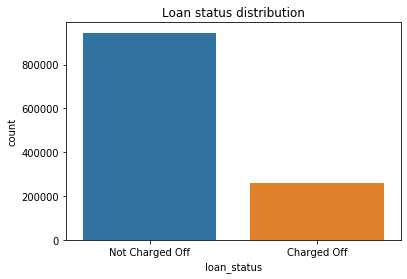

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
box_plot_df=allParts.select('loan_amnt','annual_inc','loan_status').toPandas()
ax = sns.countplot(x="loan_status", data=box_plot_df).set_title("Loan status distribution");

Insights : We can observe that the Y variable is unbalanced. It will make sense to make it balanced and train the model. In this way we can improve our prediction accuracy

#### The next major factor for any loan, is the loan amount. Let us visualise this variable

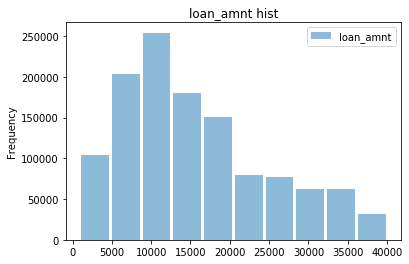

In [70]:
allParts.select('loan_amnt').toPandas().plot.hist(rwidth=0.9, alpha=0.5, title='loan_amnt hist');

Insights : Most of the p2p loans are between 5000  and  20000 dollors. It will be interesting to see how loan status behaves with loan amount.

#### Loan Status vs Loan amount

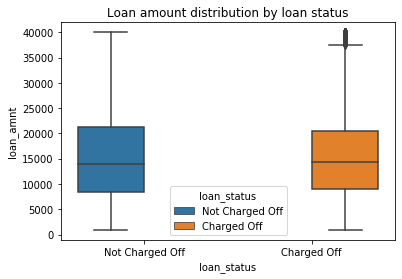

In [71]:
sns.boxplot(y='loan_amnt', x='loan_status', data=box_plot_df,hue='loan_status',   orient='v').set_title("Loan amount distribution by loan status");

Insights : We can observe slightly that the mean of charged off is a little higher than Not charged off. This tells us that the possibility of a loan amount being charged off is more for higher loans

#### Let us analyze how the interest rates are varying for the dataset

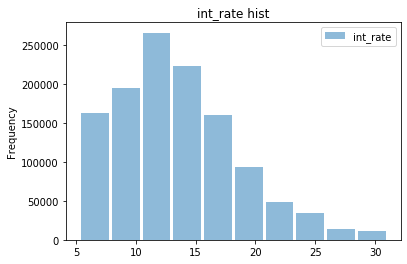

In [101]:
allParts.select('int_rate').toPandas().plot.hist(rwidth=0.9,alpha=0.5, title='int_rate hist');

Insights : most interest rates are between 5 to 15. 

#### Annual Income with loan status

In [72]:
allParts.groupby('loan_status').agg(fn.mean(fn.col('annual_inc'))).show()
#Include graphs here

+---------------+-----------------+
|    loan_status|  avg(annual_inc)|
+---------------+-----------------+
|Not Charged Off|80511.36278824105|
|    Charged Off|70327.75923285207|
+---------------+-----------------+



Insights : The average annual income for charged off is lesser than Not charged off loan status

#### PCA analysis

PCA helps us to reduce the number of variables without completely removing variables from consideration and it ensures all the variables are independent of one another. However, it will make our independent variables less interpretable than the original ones, especially in the financial field where we are not really familiar with.

In this project however, we shall not be using the PC components to train model. We just applied PCA to better understand the features that provides the maximum variance in the dataset

In [73]:
size_shape(allParts_dropped)

rows: 1206949
columns: 72


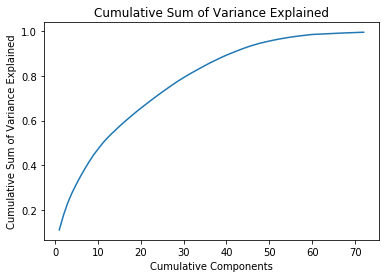

In [74]:
# Let us do a PCA plot to understand important features involved in this dataset that explains the most variance of data.
# I will train the PCA with all the columns

pca=feature.PCA(k=72, inputCol='final_features', outputCol='scores')
pca_pipe = Pipeline(stages = [allParts_pipe,pca])
pipe_pca_fit=pca_pipe.fit(allParts_dropped)
pipe_pca_fitted=pipe_pca_fit.transform(allParts_dropped)
explained_var = pipe_pca_fit.stages[-1].explainedVariance
import numpy as np
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained");

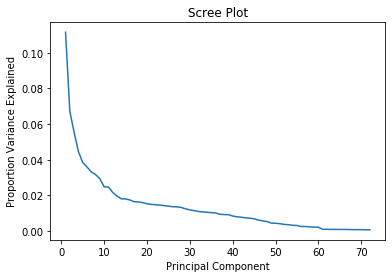

In [75]:
plt.figure()

plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained");

In [76]:
for k in range(len(cum_sum)-1): 
    best_k=k
    if (cum_sum[k+1]>0.85):
        break
print("the best_k for 80% variance is:",best_k)

the best_k for 80% variance is: 34


In [77]:
import pandas as pd
pca_model = pipe_pca_fit
# loadings = pipe_pca_fit.stages[-1].pc.toArray()
pc1 = pipe_pca_fit.stages[-1].pc.toArray()[:, 0].tolist() #loading vector
pc2 = pipe_pca_fit.stages[-1].pc.toArray()[:, 1].tolist()
vocabulary = allParts_dropped.columns
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'feature', 
                                                                     1: 'load_pc1',
                                                                     2: 'load_pc2'})
pc1_pd = pc_loadings
pc1_pd.load_pc1 = pc1_pd.load_pc1.apply(lambda x: np.abs(x))
pc2_pd = pc_loadings
pc2_pd.load_pc2 = pc2_pd.load_pc2.apply(lambda x: np.abs(x))

print(pc1_pd[['feature','load_pc1']].sort_values(by = 'load_pc1',ascending = False).head(5))
print('\n')
print(pc2_pd[['feature','load_pc2']].sort_values(by = 'load_pc2',ascending = False).head(5))

                  feature  load_pc1
53  mths_since_recent_inq  0.298758
8   annual_inc             0.298605
49  mo_sin_rcnt_rev_tl_op  0.255009
34  mths_since_rcnt_il     0.247723
51  mort_acc               0.246643


            feature  load_pc2
2   funded_amnt_inv  0.282256
1   funded_amnt      0.282208
0   loan_amnt        0.282178
36  il_util          0.253250
42  total_cu_tl      0.247533


Insights : We need only 34 principal components to represent 80% of the variance of our data. Features like mths_since_recent_inq(Months since recent inquiry , annual income..etc are the most important features that will help us in the models

# 3.PREDICTIVE ANALYSIS AND MODELS

## General Approach :-
1. Train Random Forest for all features
2. Extract the Top 20 from Random Forest.
3. Use that Top 20 to run Gradient Boosting Tree,Logistic regression model & Random Forest(Again).

### 1. Random Forest For All Features

In [78]:
trainR , testR = allParts_dropped.randomSplit([0.8,0.2],0)

rfR = classification.RandomForestClassifier(featuresCol = 'final_features',labelCol = 'encoded_loan_status',maxBins = 40,maxDepth = 7)
rf_modelR = Pipeline(stages = [allParts_pipe,rfR])
fitted_rf_pipelineR = rf_modelR.fit(trainR)
rf_modelR = fitted_rf_pipelineR.stages[-1]

bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_rf_pipelineR.transform(testR))
pd.DataFrame(list(zip(allParts_dropped.columns[2:], rf_modelR.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False).head(20)

,column,weight
14,revol_bal,0.218329
27,tot_cur_bal,0.110976
13,pub_rec,0.104601
28,open_acc_6m,0.086267
18,out_prncp,0.076501
15,revol_util,0.039347
29,open_act_il,0.036927
23,collection_recovery_fee,0.035878
24,last_pymnt_amnt,0.033547
33,total_bal_il,0.029422


### 2. Extracting only the 20 features which shall be used for further evaluation

In [79]:
col20_df = pd.DataFrame(list(zip(allParts_dropped.columns[2:], rf_modelR.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False).head(20)
# Creating a DataFrame with only these 20columns to do further analysis
new_cols = list(col20_df['column'])
spark20_df = allParts_dropped.select([col for col in new_cols]+['loan_status'])
size_shape(spark20_df)


rows: 1206949
columns: 21


### 3a. Random Forest  with TOP 20

In [88]:
spark20_df.dtypes

[('revol_bal', 'float'),
 ('tot_cur_bal', 'float'),
 ('pub_rec', 'int'),
 ('open_acc_6m', 'int'),
 ('out_prncp', 'float'),
 ('revol_util', 'float'),
 ('open_act_il', 'double'),
 ('collection_recovery_fee', 'float'),
 ('last_pymnt_amnt', 'float'),
 ('total_bal_il', 'double'),
 ('mths_since_rcnt_il', 'double'),
 ('grade', 'string'),
 ('open_il_12m', 'double'),
 ('open_il_24m', 'double'),
 ('tot_coll_amt', 'float'),
 ('collections_12_mths_ex_med', 'int'),
 ('total_acc', 'int'),
 ('bc_open_to_buy', 'double'),
 ('num_tl_90g_dpd_24m', 'double'),
 ('term', 'string'),
 ('loan_status', 'string')]

In [94]:
#Defining the Pipeline and train_test_split
revised_train , revised_test = spark20_df.randomSplit([0.8,0.2],0)
revised_pipe = Pipeline(stages = [feature.StringIndexer(inputCol = 'grade',outputCol = 'grade_coded'),
                                  feature.StringIndexer(inputCol = 'term',outputCol = 'term_coded'),
                                  feature.StringIndexer(handleInvalid='skip', inputCol='loan_status', outputCol='encoded_loan_status'),
                                  feature.VectorAssembler(inputCols=[cols for cols in new_cols if cols not in ['grade','term']]+['grade_coded','term_coded'],outputCol = 'features') ])


In [95]:
#Since most here are numerical & float


revised_rF = classification.RandomForestClassifier(featuresCol = 'features',labelCol = 'encoded_loan_status')
rf_modelR2 = Pipeline(stages = [revised_pipe,revised_rF])
fitted_rf_pipelineR2 = rf_modelR2.fit(revised_train)
# rf_modelR = fitted_rf_pipelineR2.stages[-1]
bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_rf_pipelineR2.transform(revised_test))



0.8707895222792882

### 3b. Logistic Regression with TOP 20

In [96]:

revised_Lr = classification.LogisticRegression(featuresCol = 'features',labelCol = 'encoded_loan_status')
paramGrid = ParamGridBuilder() \
    .addGrid(revised_Lr.elasticNetParam, [0., 0.01]) \
    .addGrid(revised_Lr.regParam, [0.1, 0.001]) \
    .build()

#Will take 30min to train.. so care
Lr_modelR2 = Pipeline(stages = [revised_pipe,revised_Lr])
evaluator = BinaryClassificationEvaluator(labelCol=revised_Lr.getLabelCol(), rawPredictionCol=revised_Lr.getRawPredictionCol(), numBins=40)
crossval = CrossValidator(estimator=Lr_modelR2, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)
final_model_fitted_Lr = crossval.fit(revised_train)

bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
# bceR.evaluate(final_model_fitted_Lr.transform(revised_test))

# Full Model

en_weights = final_model_fitted_Lr.bestModel.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': new_cols , 'weight': en_weights})
#Printing the words and their contribution to the prediction of sentiment.
#As expected, words like worst,waste contribute heavily to the negative review.
en_coeffs_df.sort_values('weight',ascending = False).head(15)


,word,weight
18,num_tl_90g_dpd_24m,2.052858e-01
2,pub_rec,6.281198e-02
17,bc_open_to_buy,5.945538e-02
15,collections_12_mths_ex_med,2.064703e-02
12,open_il_12m,1.356757e-02
5,revol_util,7.369290e-03
7,collection_recovery_fee,9.276526e-04
8,last_pymnt_amnt,4.875793e-05
11,grade,4.248236e-06
9,total_bal_il,3.800938e-06


### 3c.  Gradiant Boosting Model

In [97]:

gbtR = classification.GBTClassifier(featuresCol = 'features',labelCol = 'encoded_loan_status',maxBins = 40)
gbt_modelR = Pipeline(stages = [revised_pipe,gbtR])
fitted_gbt_pipelineR = gbt_modelR.fit(revised_train)



bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_gbt_pipelineR.transform(revised_test))
pd.DataFrame(list(zip(new_cols, rf_modelR.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False).head(15)

,column,weight
14,tot_coll_amt,0.218329
13,open_il_24m,0.104601
18,num_tl_90g_dpd_24m,0.076501
15,collections_12_mths_ex_med,0.039347
3,open_acc_6m,0.024014
16,total_acc,0.012053
1,tot_cur_bal,0.004861
2,pub_rec,0.004342
0,revol_bal,0.003446
7,collection_recovery_fee,0.003263


# 4.Model Evaluation & Final Conclusion

For model evaluation, we are using the metrics of AUC,precision,recall,F1-Measure to rate mdoels.
1. AUC : Tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at distinguishing between clients who will be Charged Off and those who will Not be Charged Off.
2. Precision : Is The ability of a model to identify only the relevant data points.For our example, it would be the ability of the model to correctly classify customers Lending Club will Not Charge Off
3. Recall : Is The ability of a model to find all the relevant cases within a dataset. For our example, it would be the ability of the model to find all cases where the customer is Charged Off
4. Is The weighted average of Precision and Recall.In the metric we identify real Charged Offs accounts and you are not disturbed by false alarms.



In [102]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
models = [fitted_rf_pipelineR2,final_model_fitted_Lr,fitted_gbt_pipelineR]
names = ['Random Forest Model with TOP 20','Logistic Regression with TOP 20','GBT with top 20']
for i,model in enumerate(models):
    print(names[i])
    transformed_test = model.transform(revised_test)
    predictionAndLabels = transformed_test.rdd.map(lambda lp: (float(lp.prediction), lp.encoded_loan_status))
    labels = transformed_test.rdd.map(lambda lp: lp.encoded_loan_status).distinct().collect()
    metrics = MulticlassMetrics(predictionAndLabels)
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
        

Random Forest Model with TOP 20
Class 0.0 precision = 0.8832352233617926
Class 0.0 recall = 0.9510417052140769
Class 0.0 F1 Measure = 0.9158851859771309
Class 1.0 precision = 0.7560133835656138
Class 1.0 recall = 0.5468091998704243
Class 1.0 F1 Measure = 0.6346145340351187
Logistic Regression with TOP 20
Class 0.0 precision = 0.8562463938811614
Class 0.0 recall = 0.949276013554591
Class 0.0 F1 Measure = 0.9003645261410871
Class 1.0 precision = 0.6994706674601434
Class 1.0 recall = 0.42554164522952037
Class 1.0 F1 Measure = 0.529156695021681
GBT with top 20
Class 0.0 precision = 0.8954159894477352
Class 0.0 recall = 0.9581837693816379
Class 0.0 F1 Measure = 0.9257371380706978
Class 1.0 precision = 0.7983120426323975
Class 1.0 recall = 0.5966005449798967
Class 1.0 F1 Measure = 0.6828720364675347


### From the Above metrics, we will consider GBT as the final model. Since it has the highest F-1 score.

## Future Analysis :
1. Include PCA in training of models.
2. Cross-validation and hyper parameter tuning of models.

# This Concludes the end of project code #